<a href="https://colab.research.google.com/github/Chaosbix/WasteManagement/blob/main/prepocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow scikit-learn matplotlib pandas seaborn


In [ ]:
import os
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Chemin vers le dataset
dataset_path = '/content/drive/My Drive/data/'  # Chemin correct



# Vérifier si le chemin existe
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Le chemin spécifié '{dataset_path}' n'existe pas.")

# Initialisation des variables
all_dimensions_set = set()  # Pour stocker les dimensions uniques des images
category_stats = {}  # Pour stocker les statistiques par catégorie

# Parcourir chaque catégorie
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    # Vérifier que c'est un dossier
    if os.path.isdir(category_path):
        image_files = [f for f in os.listdir(category_path) if f.endswith(('jpg', 'jpeg', 'png'))]

        # Compter les images dans la catégorie
        num_images = len(image_files)
        category_stats[category] = num_images

        # Vérifier les dimensions des images
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Afficher les statistiques par catégorie
print("\nNombre d'images par catégorie :")
for category, count in category_stats.items():
    print(f"- {category}: {count} images")

# Vérifier l'uniformité des dimensions
if len(all_dimensions_set) == 1:
    width, height, channels = next(iter(all_dimensions_set))
    print(f"\nToutes les images ont les mêmes dimensions : {width}x{height} avec {channels} canaux de couleur.")
else:
    print("\nLes images du dataset ont des dimensions ou des canaux de couleur différents.")
    print("Dimensions uniques trouvées :")
    for dimension in all_dimensions_set:
        print(f"- {dimension[0]}x{dimension[1]} avec {dimension[2]} canaux")




Nombre d'images par catégorie :
- paper: 594 images
- plastic: 482 images
- cardboard: 403 images
- glass: 501 images
- metal: 410 images
- trash: 137 images

Toutes les images ont les mêmes dimensions : 512x384 avec 3 canaux de couleur.


In [ ]:


# Construire la liste des chemins et labels
data = [
    (os.path.join(dataset_path, category, file), category, file)
    for category in os.listdir(dataset_path)
    for file in os.listdir(os.path.join(dataset_path, category))
]

# Créer le DataFrame
df = pd.DataFrame(data, columns=["filepath", "label", "filename"])

# Afficher un aperçu des données
print("Aperçu des données :")
print(df.head())


Aperçu des données :
                                           filepath  label       filename
0  /content/drive/My Drive/data/paper/paper_004.jpg  paper  paper_004.jpg
1  /content/drive/My Drive/data/paper/paper_006.jpg  paper  paper_006.jpg
2  /content/drive/My Drive/data/paper/paper_003.jpg  paper  paper_003.jpg
3  /content/drive/My Drive/data/paper/paper_025.jpg  paper  paper_025.jpg
4  /content/drive/My Drive/data/paper/paper_007.jpg  paper  paper_007.jpg


In [ ]:
# Diviser le dataset en ensemble d'entraînement et de validation avec stratification
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% des données pour la validation
    random_state=42,  # Reproductibilité
    stratify=df['label']  # Maintenir les proportions des catégories
)

# Afficher les tailles des ensembles
print(f"Nombre d'images dans l'ensemble d'entraînement : {len(train_df)}")
print(f"Nombre d'images dans l'ensemble de validation : {len(val_df)}")

# Facultatif : Afficher la répartition des classes dans chaque ensemble
print("\nRépartition des classes dans l'ensemble d'entraînement :")
print(train_df['label'].value_counts())

print("\nRépartition des classes dans l'ensemble de validation :")
print(val_df['label'].value_counts())

Nombre d'images dans l'ensemble d'entraînement : 2022
Nombre d'images dans l'ensemble de validation : 506

Répartition des classes dans l'ensemble d'entraînement :
label
paper        475
glass        401
plastic      385
metal        328
cardboard    323
trash        110
Name: count, dtype: int64

Répartition des classes dans l'ensemble de validation :
label
paper        119
glass        100
plastic       97
metal         82
cardboard     81
trash         27
Name: count, dtype: int64


In [ ]:
# Calculer la répartition des classes dans le dataset global
overall_distribution = (df['label'].value_counts(normalize=True) * 100).round(2)

# Calculer la répartition des classes dans l'ensemble d'entraînement
train_distribution = (train_df['label'].value_counts(normalize=True) * 100).round(2)

# Calculer la répartition des classes dans l'ensemble de validation
val_distribution = (val_df['label'].value_counts(normalize=True) * 100).round(2)

# Afficher les répartitions
print("Répartition des classes dans le dataset global :")
print(overall_distribution)
print('-' * 40)

print("\nRépartition des classes dans l'ensemble d'entraînement :")
print(train_distribution)
print('-' * 40)

print("\nRépartition des classes dans l'ensemble de validation :")
print(val_distribution)


Répartition des classes dans le dataset global :
label
paper        23.50
glass        19.82
plastic      19.07
metal        16.22
cardboard    15.98
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Répartition des classes dans l'ensemble d'entraînement :
label
paper        23.49
glass        19.83
plastic      19.04
metal        16.22
cardboard    15.97
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Répartition des classes dans l'ensemble de validation :
label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Générateur d'images avec augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                  # Normaliser les pixels dans [0, 1]
    rotation_range=30,                  # Rotation aléatoire jusqu'à ±30°
    width_shift_range=0.1,              # Décalage horizontal jusqu'à 10% de la largeur
    height_shift_range=0.1,             # Décalage vertical jusqu'à 10% de la hauteur
    zoom_range=0.2,                     # Zoom avant/arrière jusqu'à ±20%
    horizontal_flip=True,               # Retourner horizontalement les images
    vertical_flip=False,                # Pas de retournement vertical (utile si les objets ont un sens, comme les bouteilles)
    shear_range=0.1,                    # Transformation en cisaillement jusqu'à 10%
    brightness_range=[0.8, 1.2],        # Modifier la luminosité entre 80% et 120%
    fill_mode='nearest'                 # Remplir les zones vides après transformation avec les pixels voisins
)

# Générateur d'images sans augmentation pour la validation
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255                   # Normaliser uniquement les pixels dans [0, 1]
)




In [ ]:
# Configurer le générateur pour l'entraînement avec augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame pour les données d'entraînement
    x_col="filepath",                    # Colonne contenant les chemins des images
    y_col="label",                       # Colonne contenant les étiquettes
    target_size=(384, 384),              # Redimensionner les images à 384x384
    batch_size=32,                       # Taille des lots (batches)
    class_mode="categorical",            # Encodage one-hot pour les étiquettes
    seed=42,                             # Assure la reproductibilité
    shuffle=True,                        # Mélange les données à chaque epoch
    interpolation="bilinear"             # Interpolation bilinéaire pour un redimensionnement fluide
)

# Configurer le générateur pour la validation sans augmentation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame pour les données de validation
    x_col="filepath",                    # Colonne contenant les chemins des images
    y_col="label",                       # Colonne contenant les étiquettes
    target_size=(384, 384),              # Redimensionner les images à 384x384
    batch_size=16,                       # Taille des lots (batches)
    class_mode="categorical",            # Encodage one-hot pour les étiquettes
    seed=42,                             # Assure la reproductibilité
    shuffle=False,                       # Pas de mélange pour garantir un ordre fixe
    interpolation="bilinear"             # Interpolation bilinéaire pour un redimensionnement fluide
)

# Afficher des informations sur les générateurs
print(f"Nombre d'images pour l'entraînement : {train_generator.samples}")
print(f"Nombre d'images pour la validation : {val_generator.samples}")

Found 2022 validated image filenames belonging to 6 classes.
Found 505 validated image filenames belonging to 6 classes.
Nombre d'images pour l'entraînement : 2022
Nombre d'images pour la validation : 505


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 32


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extraire les classes et leurs indices du générateur
class_labels_sorted = list(train_generator.class_indices.keys())  # Obtenir les noms des classes triées par indice
print("Ordre des classes (trié) :", class_labels_sorted)

# Calculer les poids de classe en fonction de la distribution des labels dans train_df
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels_sorted),  # Les classes doivent être alignées avec train_generator
    y=train_df['label']                     # Les étiquettes des données d'entraînement
)

# Associer les indices des classes (train_generator.class_indices.values()) aux poids calculés
class_weights = dict(zip(train_generator.class_indices.values(), weights))

# Afficher les poids pour chaque classe
print("\nPoids de classe calculés et alignés :")
for class_name, class_idx in train_generator.class_indices.items():
    print(f"Classe '{class_name}' (Index {class_idx}): Poids = {class_weights[class_idx]:.2f}")


Ordre des classes (trié) : ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Poids de classe calculés et alignés :
Classe 'cardboard' (Index 0): Poids = 1.04
Classe 'glass' (Index 1): Poids = 0.84
Classe 'metal' (Index 2): Poids = 1.03
Classe 'paper' (Index 3): Poids = 0.71
Classe 'plastic' (Index 4): Poids = 0.88
Classe 'trash' (Index 5): Poids = 3.06


In [ ]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implements a residual block for ResNet architectures.

    Arguments:
    X           -- Input tensor of shape (batch_size, height, width, channels)
    kernel_size -- Integer, kernel size of the middle convolutional layer in the main path
    filters     -- List of integers, defining the number of filters in the main path:
                   [filters_in, filters_middle, filters_out]
    reduce      -- Boolean, whether to reduce spatial dimensions and adjust depth
    stride      -- Integer, stride for the first convolutional layer

    Returns:
    X           -- Output tensor of the residual block
    """
    # Unpack the number of filters
    F1, F2, F3 = filters

    # Save the input tensor for the shortcut path
    shortcut = X

    # Main path: Convolutional block
    # Layer 1: 1x1 Convolution (adjust depth)
    X = Conv2D(filters=F1, kernel_size=1, strides=(stride if reduce else 1),
               padding='valid', kernel_initializer=HeNormal())(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Layer 2: Convolution with kernel_size (preserve spatial dimensions)
    X = Conv2D(filters=F2, kernel_size=kernel_size, strides=1,
               padding='same', kernel_initializer=HeNormal())(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)

    # Layer 3: 1x1 Convolution (restore depth to match the shortcut)
    X = Conv2D(filters=F3, kernel_size=1, strides=1,
               padding='valid', kernel_initializer=HeNormal())(X)
    X = BatchNormalization(axis=-1)(X)

    # Shortcut path: Adjust dimensions if needed
    if reduce:
        shortcut = Conv2D(filters=F3, kernel_size=1, strides=stride,
                          padding='valid', kernel_initializer=HeNormal())(shortcut)
        shortcut = BatchNormalization(axis=-1)(shortcut)

    # Add the shortcut to the main path
    X = Add()([X, shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def ResNet_50(input_shape, num_classes):
    """
    Implements the ResNet-50 architecture for image classification.

    Arguments:
    input_shape -- Tuple, shape of the input images (height, width, channels)
    num_classes -- Integer, number of output classes for classification

    Returns:
    model -- A Keras Model instance
    """
    def conv_block(X, filters, kernel_size, stride=1, reduce=False):
        """
        Creates a residual block with or without dimensionality reduction.
        """
        return residual_block(X, kernel_size, filters, reduce=reduce, stride=stride)

    # Define the input tensor
    X_input = Input(shape=input_shape)

    # Initial convolutional block
    X = Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_initializer="he_normal")(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Block 2
    X = conv_block(X, [64, 64, 256], kernel_size=3, reduce=True, stride=1)
    for _ in range(2):
        X = conv_block(X, [64, 64, 256], kernel_size=3)

    # Block 3
    X = conv_block(X, [128, 128, 512], kernel_size=3, reduce=True, stride=2)
    for _ in range(3):
        X = conv_block(X, [128, 128, 512], kernel_size=3)

    # Block 4
    X = conv_block(X, [256, 256, 1024], kernel_size=3, reduce=True, stride=2)
    for _ in range(5):
        X = conv_block(X, [256, 256, 1024], kernel_size=3)

    # Block 5
    X = conv_block(X, [512, 512, 2048], kernel_size=3, reduce=True, stride=2)
    for _ in range(2):
        X = conv_block(X, [512, 512, 2048], kernel_size=3)

    # Global Average Pooling + Fully Connected Layer
    X = GlobalAveragePooling2D()(X)
    X = Dense(num_classes, activation="softmax")(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="ResNet50")

    return model

In [ ]:
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
    GlobalAveragePooling2D, Dropout, Dense
)
from tensorflow.keras.models import Model


def Modified_ResNet50(input_shape, num_classes):
    """
    Implements a modified version of ResNet-50 with Dropout for regularization.

    Arguments:
    input_shape -- Tuple, shape of input images (height, width, channels)
    num_classes -- Integer, number of output classes for classification

    Returns:
    model -- A Keras Model instance
    """

    def residual_block(X, kernel_size, filters, reduce=False, stride=1):
        """
        Residual block implementation. Supports downsampling when `reduce=True`.
        """
        F1, F2, F3 = filters

        # Save input tensor for shortcut connection
        shortcut = X

        # Main Path
        X = Conv2D(F1, (1, 1), strides=(stride if reduce else 1), padding="valid",
                   kernel_initializer="he_normal")(X)
        X = BatchNormalization()(X)
        X = Activation("relu")(X)

        X = Conv2D(F2, (kernel_size, kernel_size), strides=1, padding="same",
                   kernel_initializer="he_normal")(X)
        X = BatchNormalization()(X)
        X = Activation("relu")(X)

        X = Conv2D(F3, (1, 1), strides=1, padding="valid",
                   kernel_initializer="he_normal")(X)
        X = BatchNormalization()(X)

        # Shortcut Path
        if reduce:
            shortcut = Conv2D(F3, (1, 1), strides=stride, padding="valid",
                              kernel_initializer="he_normal")(shortcut)
            shortcut = BatchNormalization()(shortcut)

        # Add Shortcut to Main Path
        X = Activation("relu")(X + shortcut)
        return X

    # Define the input tensor
    X_input = Input(shape=input_shape)

    # Stage 1: Initial Convolution + MaxPooling
    X = Conv2D(64, (7, 7), strides=(2, 2), padding="same", kernel_initializer="he_normal")(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(X)

    # Stage 2: Residual Blocks
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    for _ in range(2):
        X = residual_block(X, 3, [64, 64, 256])

    # Stage 3: Residual Blocks
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    for _ in range(3):
        X = residual_block(X, 3, [128, 128, 512])

    # Stage 4: Residual Blocks
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    for _ in range(5):
        X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5: Residual Blocks
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    for _ in range(2):
        X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling + Dropout
    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.5)(X)

    # Fully Connected Layer (Classification)
    X = Dense(num_classes, activation="softmax")(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name="Modified_ResNet50")

    return model


In [ ]:


# Définir la forme des images en entrée et le nombre de classes à prédire
input_shape = (384, 384, 3)  # Images RGB (3 canaux) de taille 384x384
num_classes = 6  # Par exemple, 6 catégories à prédire (classes)

# Initialiser le modèle ResNet-50 modifié avec les paramètres définis
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, num_classes=num_classes)




In [ ]:
modified_resnet50_model.summary()


Model: "Modified_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 192, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 192, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 192, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 96, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 96, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96, 96, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 96, 96, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 96, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 96, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 96, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 96, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 96, 96, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 96, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 96, 96, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 96, 96, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# 🛠 Préparer le modèle pour l'entraînement

# Compiler le modèle avec les paramètres nécessaires pour l'apprentissage
modified_resnet50_model.compile(
    optimizer='adam',                    # Optimiseur Adam, qui ajuste dynamiquement le taux d'apprentissage
    loss='categorical_crossentropy',     # Fonction de perte pour une classification multi-classes
    metrics=['accuracy']                 # Métrique pour mesurer la précision globale pendant l'entraînement
)



In [ ]:
# 🛠 Ajouter le callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',         # Surveille la perte sur l'ensemble de validation
    factor=0.5,                 # Réduit le taux d'apprentissage de 50% en cas de plateau
    patience=15,                # Attend 15 epochs sans amélioration avant de réduire le taux d'apprentissage
    min_lr=0.00001              # Définit un taux d'apprentissage minimal pour éviter qu'il devienne trop petit
)

# 🛠 Ajouter le callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',         # Surveille la perte sur l'ensemble de validation
    mode='min',                 # Cherche à minimiser la perte
    patience=50,                # Arrête l'entraînement après 50 epochs sans amélioration
    restore_best_weights=True,  # Rétablit les poids correspondant à la meilleure performance de validation
    verbose=1                   # Affiche des messages dans la console lorsque l'entraînement s'arrête
)

In [ ]:
# Nombre total d'époques pour l'entraînement
num_epochs = 200  # Définit le maximum d'époques possibles pour l'entraînement

# 🛠 Entraîner le modèle
history = modified_resnet50_model.fit(
    train_generator,                   # Générateur pour les données d'entraînement (images + étiquettes)
    steps_per_epoch=len(train_generator),  # Nombre de batches par époque pour l'entraînement
    epochs=num_epochs,                 # Nombre maximal d'époques pour l'entraînement
    validation_data=val_generator,     # Générateur pour les données de validation
    validation_steps=len(val_generator),  # Nombre de batches par époque pour la validation
    class_weight=class_weights,        # Poids de classe pour gérer les classes déséquilibrées
    callbacks=[reduce_lr, early_stopping]  # Callbacks pour optimiser le processus d'entraînement
)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.3023 - loss: 2.5744 - val_accuracy: 0.1624 - val_loss: 1530.3196 - learning_rate: 0.0010
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/200


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate
  current = self.get_monitor_value(logs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4351 - loss: 1.4770 - val_accuracy: 0.2079 - val_loss: 2.0033 - learning_rate: 0.0010
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4310 - loss: 1.4145 - val_accuracy: 0.2733 - val_loss: 6.3559 - learning_rate: 0.0010
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.4472 - loss: 1.4905 - val_accuracy: 0.2812 - val_loss: 1.8656 - learning_rate: 0.0010
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.4586 - loss: 1.3837 - val_accuracy: 0.3960 - val_loss: 2.6989 - learning_rate: 0.0010
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/st

In [ ]:
def clean_and_plot_learning_curves(history, start_epoch=5):
    """
    Nettoie l'historique d'entraînement pour exclure les époques avec des valeurs incohérentes,
    tronque les métriques à des longueurs égales, et trace les courbes de perte et de précision.

    Paramètres :
    - history : Historique de l'entraînement (sortie de la méthode fit du modèle).
    - start_epoch : Époque à partir de laquelle commencer le tracé. Par défaut, 5 (trace à partir de l'époque 6).
    """
    # Calculer la longueur minimale des métriques
    min_length = min(len(value) for value in history.history.values())

    # Tronquer toutes les métriques à cette longueur
    truncated_history = {key: value[:min_length] for key, value in history.history.items()}

    # Convertir en DataFrame
    df = pd.DataFrame(truncated_history)

    # Supprimer les époques avec des valeurs incohérentes
    df_cleaned = df[(df['accuracy'] > 0) & (df['loss'] > 0)]

    # Filtrer à partir de l'époque spécifiée
    df_cleaned = df_cleaned.iloc[start_epoch-1:]

    # Configurer le style visuel
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Tracer les courbes
    plt.figure(figsize=(15, 6))

    # Courbe de perte (loss)
    plt.subplot(1, 2, 1)
    if 'loss' in df_cleaned.columns:
        sns.lineplot(x=df_cleaned.index, y=df_cleaned['loss'], color='royalblue', label='Perte Entraînement')
    if 'val_loss' in df_cleaned.columns:
        sns.lineplot(x=df_cleaned.index, y=df_cleaned['val_loss'], color='orangered', linestyle='--', label='Perte Validation')
    plt.title("Évolution de la Perte")
    plt.xlabel("Époque")
    plt.ylabel("Perte")
    plt.legend()

    # Courbe de précision (accuracy)
    plt.subplot(1, 2, 2)
    if 'accuracy' in df_cleaned.columns:
        sns.lineplot(x=df_cleaned.index, y=df_cleaned['accuracy'], color='royalblue', label='Précision Entraînement')
    if 'val_accuracy' in df_cleaned.columns:
        sns.lineplot(x=df_cleaned.index, y=df_cleaned['val_accuracy'], color='orangered', linestyle='--', label='Précision Validation')
    plt.title("Évolution de la Précision")
    plt.xlabel("Époque")
    plt.ylabel("Précision")
    plt.legend()

    # Afficher les graphes
    plt.show()


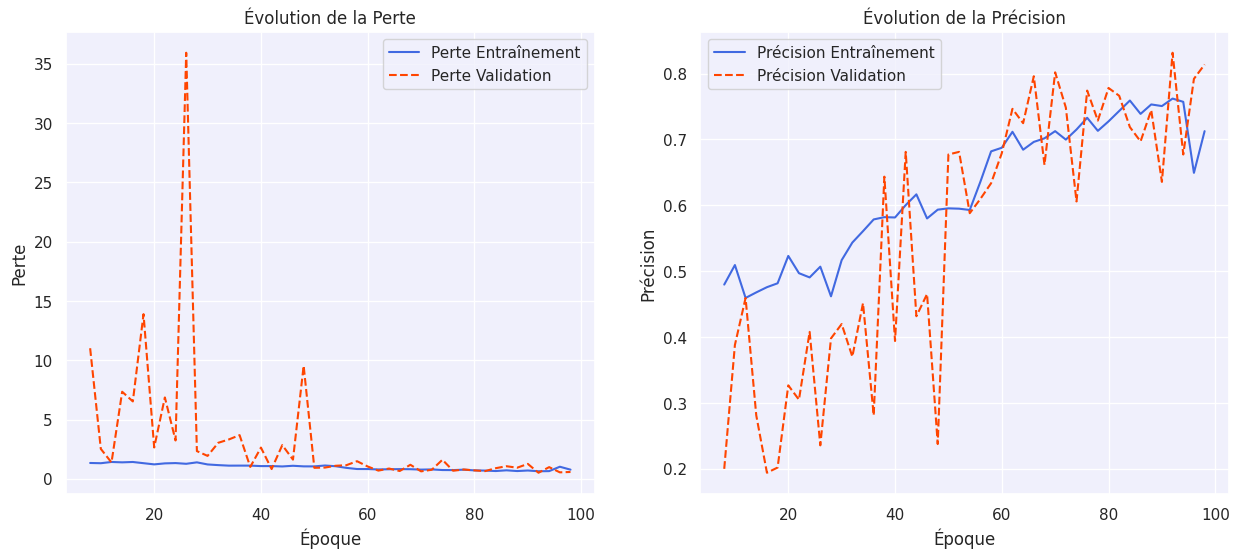

In [ ]:
clean_and_plot_learning_curves(history)



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def evaluate_model_performance(model, val_generator, class_labels):
    """
    Évalue les performances du modèle sur le jeu de validation et affiche un rapport de classification
    ainsi qu'une matrice de confusion.

    Paramètres :
    - model : Modèle entraîné.
    - val_generator : Générateur de données pour l'ensemble de validation.
    - class_labels : Liste des noms des classes.

    Retourne :
    - report : Rapport de classification au format string.
    """
    # Obtenir les étiquettes réelles (vraies classes) du jeu de validation
    true_labels = val_generator.classes

    # Prédire les étiquettes sur le jeu de validation
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Convertir les probabilités en indices de classes prédites
    predicted_labels = np.argmax(predictions, axis=1)

    # Générer le rapport de classification
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print("📊 Rapport de Classification :")
    print(report)
    print('\n')

    # Définir une palette de couleurs pour la matrice de confusion
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Calculer la matrice de confusion
    cm = confusion_matrix(true_labels, predicted_labels)

    # Tracer la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d',
                xticklabels=class_labels, yticklabels=class_labels, cbar=False)
    plt.xlabel('Étiquettes Prédites')
    plt.ylabel('Étiquettes Réelles')
    plt.title('Matrice de Confusion')
    plt.show()

    return report


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step
📊 Rapport de Classification :
              precision    recall  f1-score   support

   cardboard       0.87      0.91      0.89        80
       glass       0.85      0.76      0.80       100
       metal       0.86      0.79      0.82        82
       paper       0.91      0.91      0.91       119
     plastic       0.78      0.85      0.81        97
       trash       0.69      0.81      0.75        27

    accuracy                           0.84       505
   macro avg       0.83      0.84      0.83       505
weighted avg       0.85      0.84      0.84       505





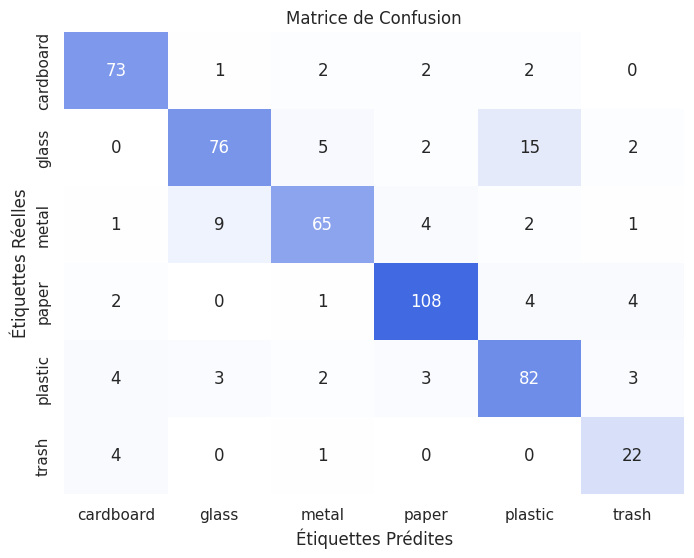

'              precision    recall  f1-score   support\n\n   cardboard       0.87      0.91      0.89        80\n       glass       0.85      0.76      0.80       100\n       metal       0.86      0.79      0.82        82\n       paper       0.91      0.91      0.91       119\n     plastic       0.78      0.85      0.81        97\n       trash       0.69      0.81      0.75        27\n\n    accuracy                           0.84       505\n   macro avg       0.83      0.84      0.83       505\nweighted avg       0.85      0.84      0.84       505\n'

In [ ]:
evaluate_model_performance(modified_resnet50_model, val_generator, class_labels_sorted)


In [ ]:
# Sauvegarde au format Keras
model_path_keras = "/content/drive/My Drive/modified_resnet50_model.keras"
modified_resnet50_model.save(model_path_keras)

